In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
print(len(X_train))
print(len(X_test))

60000
10000


In [4]:
#normalisasi dataset
X_train = X_train/255
X_test = X_test/255

In [5]:
X_train[0].shape

(28, 28)

In [6]:
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

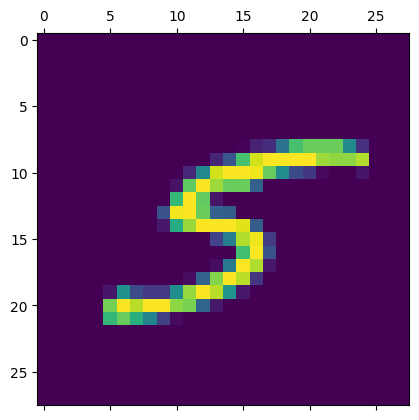

In [7]:
plt.matshow(X_train[523])

In [8]:
print(X_train.shape)
X_train_flattened = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test_flattened = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train_flattened.shape

(60000, 28, 28)


(60000, 784)

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train[0].shape[0], X_train[0].shape[1])),
    #10 -> output, input shape itu jumlah neuran, y->klo input ada channelnya
    keras.layers.Dense(100, input_shape=(X_train_flattened.shape[1], ), activation='relu'),
    keras.layers.Dense(40, input_shape=(X_train_flattened.shape[1], ), activation='relu'),
    keras.layers.Dense(10, input_shape=(X_train_flattened.shape[1], ), activation='sigmoid')
])

model.compile(
    optimizer='adam', #fungsi untuk mencapai global optima secara efisien ketika melakukan backward error propagation
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(X_train, y_train, epochs=10)



Epoch 1/10


1875/1875 [==============================] - 7s 3ms/step - loss: 0.2721 - accuracy: 0.9198
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1160 - accuracy: 0.9657
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0800 - accuracy: 0.9752
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0620 - accuracy: 0.9807
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0510 - accuracy: 0.9836
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0377 - accuracy: 0.9879
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0292 - accuracy: 0.9903
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0240 - accuracy: 0.9922
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0

In [10]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9746


[0.10012032836675644, 0.9746000170707703]

In [11]:
model.save("./saved_model")

INFO:tensorflow:Assets written to: ./saved_model\assets


INFO:tensorflow:Assets written to: ./saved_model\assets


Post training quantization

In [12]:
import tensorflow as tf

In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [14]:
len(tflite_model)

334172

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [16]:
len(tflite_quant_model)

87080

In [18]:
with open ("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

(2) Quantization aware training

In [19]:
import tensorflow_model_optimization as tfmot

In [20]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 100)               78505     
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 40)                4045      
 pperV2)                                                         
                                                                 
 quant_dense_2 (QuantizeWra  (None, 10)                4

In [21]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 10s 4ms/step - loss: 0.0235 - accuracy: 0.9921


In [22]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1079 - accuracy: 0.9754


[0.10791357606649399, 0.9753999710083008]

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp42_gox34\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp42_gox34\assets
c:\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [24]:
len(tflite_qaware_model)

86888

In [25]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

In [ ]:
model_aware_lite = TensorflowLiteClassificationModel("path/to/model.tflite")